## Mod 6 Lecture 4 Data Challenge:  Simple Linear Regression

### Purpose

**Purpose**: Run a simple linear regression (SLR) on the NYC Yellow Taxi Dec 2023 excerpt to explain how a single input (X) relates to Tip % (Y). Practice picking a sensible X, fitting the line, and interpreting β₁, p‑value, and 95% confidence interval—plus basic assumption checks.

### Data
We are looking at ONE month's worth of data (December 2023 to be exact).  Remember the data dictionary is found [HERE](https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data)

### Instructor Guidance (10 Minutes)

#### Goals

- Pick an X with a plausible relationship to Tip % that is available at trip time.

- Communicate β₁ with units, p-vale, and a 95% CI.

#### Special considerations

- `Tip %` is `tip_amount / fare_amount`. Choosing `fare_amount` as X can create a built‑in relationship because it’s in the definition of Y (mathematical coupling). Encourage alternative X’s like `trip_distance`, `pickup_hour (as numeric)`, or `passenger_count`.

- Linearity check: Is the relationship roughly straight‑line? If X is discrete (e.g., passenger_count), SLR still works but discuss meaning.

- Intercept meaning: If X=0 is unrealistic (0 miles), say the intercept is just a mathematical anchor.

- Outliers: Large distances/fares can dominate. Consider trimming extremes thoughtfully or explaining how you would handle outliers.  

#### Critical thinking prompts as you work through the challenge (be prepared to answer at the end):

- Which input would you use to make a decision before the ride starts? Why?

- If β₁ is tiny but the p‑value is very small, is that useful for the business?

- If residuals (can only get residuals after fitting the model) "fan out" as X grows, what story might that tell about tipping behavior?

- Would your conclusion change if you looked at daytime vs. late night rides separately?

### Student Tasks (35 minutes)

Step 0 — Load Packages and Data, Fix Data Types, Create Tip % Column 

**Hint**:  You did this in the Code-Along, refer back to the notebook to help you!

In [8]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/Yellow_Taxi_Data.csv", low_memory=False)
display(df.head())
display(df.info())
display(df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3,0.0,1.0,17.4,2.5,0.0
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0,1.1,1.0,N,236,263,2,10,5.0,0.5,0,0.0,1.0,16.5,2.5,0.0
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0,0.0,-1.0,-17.2,-2.5,0.0
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0,0.0,1.0,17.2,2.5,0.0
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0,3,1.0,N,164,211,1,21.9,5.0,0.5,3,0.0,1.0,31.4,2.5,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,3.310907e+06,3.133527e+06,3.133527e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.133527e+06,3.133527e+06
mean,1.750368e+00,1.409560e+00,1.784972e+00,1.650685e+02,1.639182e+02,1.168633e+00,1.485240e+00,4.828656e-01,5.734011e-01,9.758456e-01,2.270032e+00,1.367974e-01
std,4.356449e-01,9.117169e-01,8.283274e+00,6.428330e+01,6.968454e+01,5.959677e-01,1.814139e+00,1.206643e-01,2.228458e+00,2.170912e-01,8.078364e-01,4.796868e-01
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-3.917000e+01,-5.000000e-01,-7.000000e+01,-1.000000e+00,-2.500000e+00,-1.750000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.500000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
max,6.000000e+00,9.000000e+00,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.168000e+01,4.217000e+01,1.613800e+02,1.000000e+00,2.500000e+00,1.750000e+00


Step 1 — Choose Your X (be sure to chose an X variable that would be available at trip time (not after the trip takes place))

Add a 2–3 sentence rationale in Markdown: Why could X relate to `tip_pct`? Why is it available **when the decision is made** (meaning driver has the information before the actual drive takes place)?

In [4]:
num_cols = ['fare_amount', 'tip_amount', 'passenger_count']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'
)
    
df = df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0) & (df['passenger_count'] > 0)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)
df['tip_pct'] = (df['tip_amount']/df['fare_amount']).clip(0,1)

I chose df['passenger_count'] as my X variable because the number of passengers likely influences the tip amount. This information is available at the start of the ride, as the driver can see how many people are boarding, and many taxi apps adjust ride types based on passenger count.

Step 2 — Quick Visual Check (Linearity & Outliers)

Add a 2-3 sentence rationale on how you would handle outliers or how you did handle outliers (if you handled them for this challenge).  Is the linear relationship there between your X and Y?  Is it a strong relationship?  What is the benefits of a strong relationship between X and Y?

<Axes: ylabel='Frequency'>

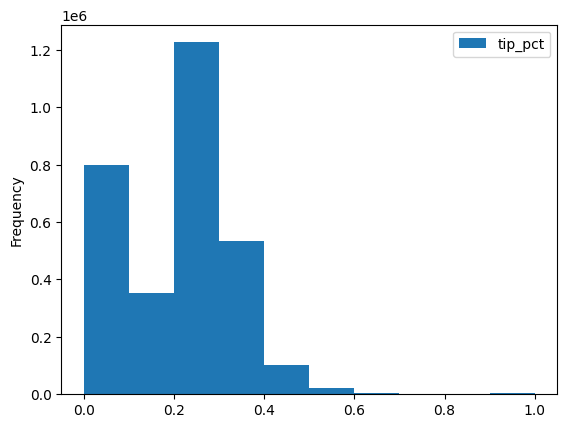

In [5]:
df.plot(x='passenger_count',y='tip_pct',kind='hist')

To handle outliers, I followed the same approach from our code-along, removing any negative values in the three columns used. Since my X variable is discrete, the relationship with Y doesn’t appear linear—the scatter plot shows the data clustered along a few vertical lines.

Step 3 — Fit SLR Model to Data

In [6]:
X = sm.add_constant(df[['passenger_count']]) 
y = df['tip_pct']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tip_pct   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3624.
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:52:18   Log-Likelihood:             1.6736e+06
No. Observations:             3052164   AIC:                        -3.347e+06
Df Residuals:                 3052162   BIC:                        -3.347e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2116      0.000   1413.701      0.000       0.211       0.212
passenger_count    -0.0053   8.86e-05    -60.202      0.000      -0.006      -0.005
==============================================================================
Omnibus:                    91134.662   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           192527.487
Skew:                           0.191   Prob(JB):                         0.00
Kurtosis:                       4.170   Cond. No.                         4.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Step 4 — Interpret the model's coefficients, p-values, and CI 


There appears to be a slight negative correlation between "passenger_count" and "tip percentage". The small p-value indicates the model detected a relationship, but the wide confidence interval suggests high variability across the range of "tip percentages".

Step 5 — Post‑Fit Assumption Glance 

Add 2-3 sentences about the residuals any curve? funnel shape? obvious outliers?  How would you go about checking if residuals were normally distributed?  

There’s no clear curve or funnel pattern, as the data clusters along discrete X-values. The large number of residuals likely makes it hard to see any real trend.

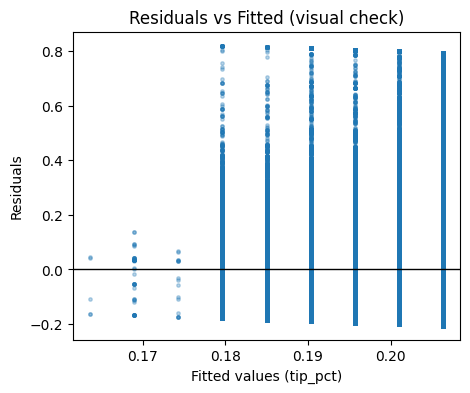

In [9]:
#RUN THIS CELL WITHOUT CHANGES
resid = model.resid
fitted = model.fittedvalues
plt.figure(figsize=(5,4))
plt.scatter(fitted, resid, s=6, alpha=0.3)
plt.axhline(0, color='k', lw=1)
plt.xlabel('Fitted values (tip_pct)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (visual check)')
plt.show()

### Reflection (10-15 mins)

**In addition to the critical thinking questions at the top** of the notebook be prepared to discuss: 

- If you had to make a decision tomorrow, would this simple model be enough? Why/why not?

- What’s one different X you’d try next and why?

1. No, this simple model wouldn’t be enough since passenger count alone doesn’t strongly predict tip percentage. More variables are likely needed for better accuracy.

2. I’d try trip distance next, as longer rides might lead to higher tips due to increased fare and service time.